# Example Notebook

This notebook implements many of the examples presented in the paper.


In [1]:
import grama as gr
import numpy as np
import pandas as pd
DF = gr.Intention()
gr.hide_traceback() # To simplify errors shown in Jupyter
%matplotlib inline

# Grama

## Core Functionality


In [2]:
md_example = (
    gr.Model("An example model")
    # Overloaded `>>` provides pipe syntax
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(f=df.x+df.y+df.z),
        var=["x", "y", "z"],
        out=["f"],
    )
    >> gr.cp_bounds(x=(-1, +1))
    >> gr.cp_marginals(
        y=gr.marg_mom("norm", mean=0, sd=1),
        z=gr.marg_mom("uniform", mean=0, sd=1),
    )
    >> gr.cp_copula_gaussian(
        df_corr=gr.df_make(var1="y", var2="z", corr=0.5)
    )
)

The model representation presents a helpful summary:


In [3]:
md_example

/Users/zach/Git/py_grama/grama/marginals.py:336: RuntimeWarning: divide by zero encountered in double_scalars


model: An example model

  inputs:
    var_det:
      x: [-1, 1]

    var_rand:
      y: (+0) norm, {'mean': '0.000e+00', 's.d.': '1.000e+00', 'COV': inf, 'skew.': 0.0, 'kurt.': 3.0}
      z: (+0) uniform, {'mean': '0.000e+00', 's.d.': '1.000e+00', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}

    copula:
      Gaussian copula with correlations:
  var1 var2  corr
0    y    z   0.5

  functions:
      f0: ['x', 'y', 'z'] -> ['f']

Construct a default parameter sweep


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Calling plot_sinew_outputs....


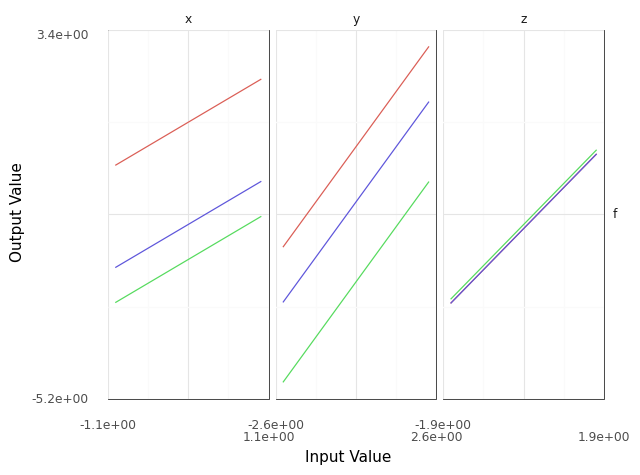

<ggplot: (8765340788697)>

In [4]:
(
    md_example
    >> gr.ev_sinews(df_det="swp")
    >> gr.pt_auto()
)

## Function Defaults

Most concise form: Evaluate a model with default arguments, construct an automatic plot.


In [5]:
p = (
    md_example
    >> gr.ev_sinews(df_det="swp") # Default parameters
    >> gr.pt_auto()               # Default visual
)
p.save("example-sweep.png")

Calling plot_sinew_outputs....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: example-sweep.png
/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Override the evaluation default to produce more sweeps.


Calling plot_sinew_outputs....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


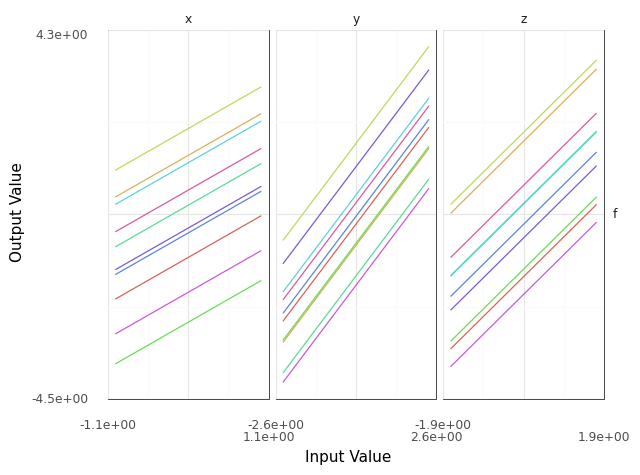

<ggplot: (8765323858170)>

In [6]:
(
    md_example
    ## Override default parameters
    >> gr.ev_sinews(df_det="swp", n_sweeps=10)
    >> gr.pt_auto()
)

Override the autoplot to construct a more targeted manual plot.


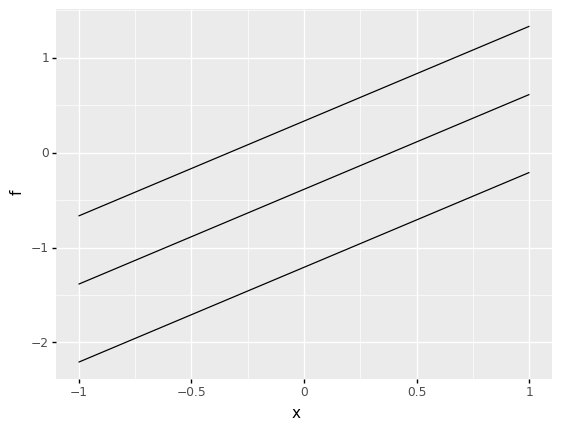

<ggplot: (8765332735501)>

In [7]:
(
    md_example
    >> gr.ev_sinews(df_det="swp")
    ## Construct a manual plot
    >> gr.tf_filter(DF.sweep_var == "x")
    >> gr.ggplot(gr.aes("x", "f", group="sweep_ind"))
    + gr.geom_line()
)

# Case Studies


## 1. Planned Errors as Teachable Moments

It is possible to define a grama model without a copula:


In [8]:
md_flawed = (
    gr.Model("An example model")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(f=df.x+df.y+df.z),
        var=["x", "y", "z"],
        out=["f"],
    )
    >> gr.cp_bounds(x=(-1, +1))
    >> gr.cp_marginals(
        y=gr.marg_mom("norm", mean=0, sd=1),
        z=gr.marg_mom("uniform", mean=0, sd=1),
    )
)


However, this flawed model will throw an error when used in a probabilistic analysis:


In [9]:
(
    md_flawed
    >> gr.ev_sample(n=1000, df_det="nom")
)

ValueError: 
Present model copula must be defined for sampling.
Use CopulaIndependence only when inputs can be guaranteed
independent. See the Documentation chapter on Random
Variable Modeling for more information.
https://py-grama.readthedocs.io/en/latest/source/rv_modeling.html

## 2. Encouraging Sound Analysis


A comparative example

### Manual approach


In [10]:
## Manual coordination
# Model data
x_lo = -1; x_up = +1; 
y_lo = -1; y_up = +1;
f_model = lambda x, y: x**2 * y
# Analysis parameters
nx = 10               # Grid resolution for x
y_const = [-1, 0, +1] # Constant values for y
# Generate data
data = np.zeros((nx * len(y_const), 3))
for i, x in enumerate(np.linspace(x_lo, x_up, num=nx)):
    for j, y in enumerate(y_const):
        data[i + j*nx, 0] = f_model(x, y)
        data[i + j*nx, 1] = x
        data[i + j*nx, 2] = y
# Package for visual
df_manual = pd.DataFrame(
    data=data,
    columns=["f", "x", "y"],
)

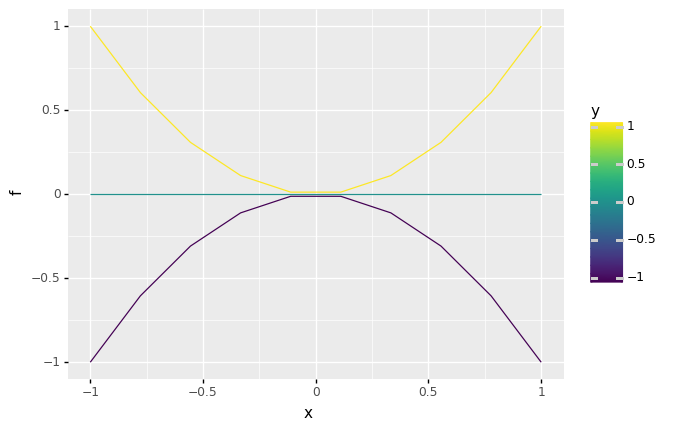

<ggplot: (8765362710010)>

In [11]:
(
    df_manual
    >> gr.ggplot(gr.aes("x", "f", group="y", color="y"))
    + gr.geom_line()
)

### Grama approach


In [12]:
## Grama approach
# Model data
md_gr = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(f=df.x**2 * df.y),
        var=["x", "y"],
        out=["f"],
    )
    >> gr.cp_bounds(
        x=(-1, +1),
        y=(-1, +1),
    )
)
# Generate data
df_gr = gr.eval_sinews(
    md_gr,
    df_det="swp",
    n_sweeps=3,
)

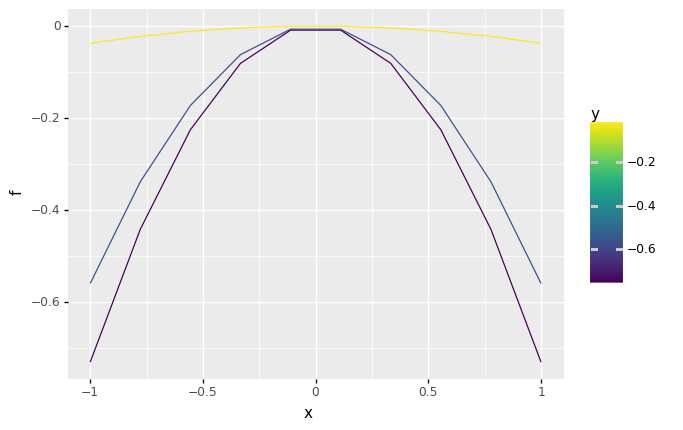

<ggplot: (8765332851008)>

In [13]:
(
    df_gr
    >> gr.tf_filter(DF.sweep_var == "x")
    >> gr.ggplot(gr.aes("x", "f", group="y", color="y"))
    + gr.geom_line()
)

### In-the-wild Example


```python
md_car = (
    gr.Model("Accel Model")
    >> gr.cp_function(
        fun = calculate_finish_time,
        var = ["GR", "dt_mass", "I_net" ],
        out = ["finish_time"],
    )

    >> gr.cp_bounds(
        GR=(+1,+4),
        dt_mass=(+5,+15),
        I_net=(+.2,+.3),
    )
)

gr.plot_auto(
    gr.eval_sinews(
        md_car,
        df_det="swp",
        #skip=True,
        n_density=20,
        n_sweeps=5,
        seed=101,
    )
)
```

The following is the cropped form of the student parameter sweep, presented in the paper.

![](student-sweep-focus.png)


The following is the full version of the original student plot.

![](student-sweep.png)


## 3. Exploratory Model Analysis
